In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

from ipynb.fs.full.UtilFunctions import format_season

In [2]:
def pre_process(seasons):
    df = None
    for season in seasons:
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if season > 1997:
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=['index'], inplace=True)
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [3]:
def random_forest_classify(X_train, y_train, X_test):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5)
    rand_search.fit(X_train, y_train)
    best_rf = rand_search.best_estimator_
    return best_rf.predict(X_test)

## Pre-processing - gathering data from the last 6 seasons

In [4]:
df = pre_process(range(2017, 2023))

## Feature selection, splitting into training/testing

In [5]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

## Randomly select better parameters for Random Forest and fit the data

In [6]:
y_pred = random_forest_classify(X_train, y_train, X_test)

## Evaluating Random Forest results with Confusion Matrix and accuracy score

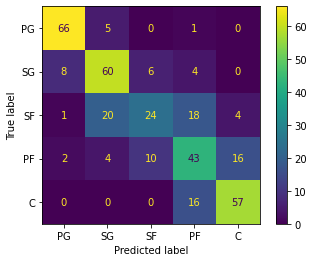

In [7]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [8]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.684931506849315

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.74      0.78      0.76        73
          PF       0.52      0.57      0.55        75
          PG       0.86      0.92      0.89        72
          SF       0.60      0.36      0.45        67
          SG       0.67      0.77      0.72        78

    accuracy                           0.68       365
   macro avg       0.68      0.68      0.67       365
weighted avg       0.68      0.68      0.68       365



## Visualize trees from random forest with Graphviz

In [ ]:
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=5, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but with data from the early 2000s

## Feature selection, splitting into training/testing

In [10]:
old_df = pre_process(range(2000, 2006))

In [11]:
features = old_df.loc[:, ~old_df.columns.isin(["Player", "Pos", "Tm"])]
target = old_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

## Randomly select better parameters for Random Forest and fit the data

In [12]:
y_pred = random_forest_classify(X_train, y_train, X_test)

## Evaluating Random Forest results with Confusion Matrix and accuracy score

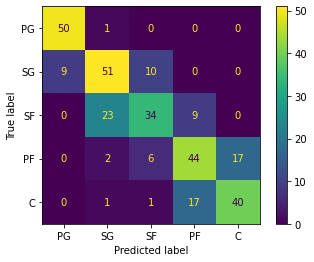

In [13]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [14]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6952380952380952

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.70      0.68      0.69        59
          PF       0.63      0.64      0.63        69
          PG       0.85      0.98      0.91        51
          SF       0.67      0.52      0.58        66
          SG       0.65      0.73      0.69        70

    accuracy                           0.70       315
   macro avg       0.70      0.71      0.70       315
weighted avg       0.69      0.70      0.69       315



## Visualize trees from random forest with Graphviz

In [ ]:
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=5, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but training with recent seasons and predicting old ones

## Splitting into training/testing

In [16]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

old_features = old_df.loc[:, ~old_df.columns.isin(["Player", "Pos", "Tm"])]
old_target = old_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)
old_X_train, old_X_test, old_y_train, old_y_test = train_test_split(old_features, old_target, test_size = 0.2)

## Randomly select better parameters for Random Forest and fit the data

In [17]:
y_pred = random_forest_classify(X_train, y_train, old_X_test)

## Evaluating Random Forest results with Confusion Matrix and accuracy score

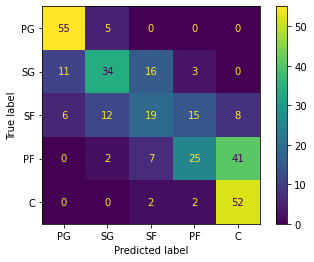

In [18]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(old_y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [19]:
accuracy = accuracy_score(old_y_test, y_pred)
accuracy

0.5873015873015873

In [21]:
print(classification_report(old_y_test, y_pred))

              precision    recall  f1-score   support

           C       0.51      0.93      0.66        56
          PF       0.56      0.33      0.42        75
          PG       0.76      0.92      0.83        60
          SF       0.43      0.32      0.37        60
          SG       0.64      0.53      0.58        64

    accuracy                           0.59       315
   macro avg       0.58      0.61      0.57       315
weighted avg       0.58      0.59      0.56       315



## Visualize trees from random forest with Graphviz

In [ ]:
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=5, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but training with old seasons and predicting recent ones

## Randomly select better parameters for Random Forest and fit the data

In [22]:
y_pred = random_forest_classify(old_X_train, old_y_train, X_test)

## Evaluating Random Forest results with Confusion Matrix and accuracy score

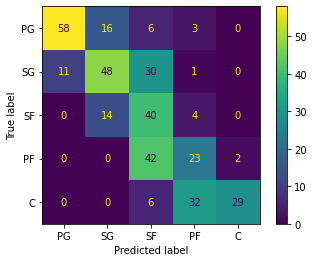

In [23]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [24]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5424657534246575

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.94      0.43      0.59        67
          PF       0.37      0.34      0.35        67
          PG       0.84      0.70      0.76        83
          SF       0.32      0.69      0.44        58
          SG       0.62      0.53      0.57        90

    accuracy                           0.54       365
   macro avg       0.62      0.54      0.54       365
weighted avg       0.63      0.54      0.56       365



## Visualize trees from random forest with Graphviz

In [ ]:
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=5, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, with the first seasons with the 3-point line

In [26]:
first_dfs = []

In [27]:
for season in range(1980,1986):
    first_year, second_year = format_season(season)
    player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")    
    player_data = player_data.fillna(0)
    player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
    player_data = player_data.sort_values(by=['G'], ascending=False)
    player_data = player_data[player_data["Tm"] != "TOT"]
    player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
    player_data.reset_index(inplace=True)
    player_data.drop(columns=['index'], inplace=True)
    
    first_dfs.append(player_data)

In [28]:
first_df = first_dfs[0]
for i in range(1, len(first_dfs)):
    first_df = pd.concat([first_df, first_dfs[i]])
    
first_df.reset_index(inplace=True)
first_df.drop('index', axis=1, inplace=True)

In [29]:
first_df = pre_process(range(1980, 1988))

## Splitting into training/testing

In [30]:
features = first_df.loc[:, ~first_df.columns.isin(["Player", "Pos", "Tm"])]
target = first_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

## Randomly select better parameters for Random Forest and fit the data

In [31]:
y_pred = random_forest_classify(X_train, y_train, X_test)

## Evaluating Random Forest results with Confusion Matrix and accuracy score

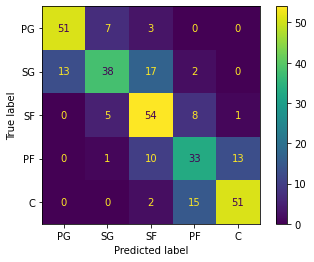

In [32]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [33]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7006172839506173

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.78      0.75      0.77        68
          PF       0.57      0.58      0.57        57
          PG       0.80      0.84      0.82        61
          SF       0.63      0.79      0.70        68
          SG       0.75      0.54      0.63        70

    accuracy                           0.70       324
   macro avg       0.70      0.70      0.70       324
weighted avg       0.71      0.70      0.70       324



## Visualize trees from random forest with Graphviz

In [ ]:
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=5, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)